In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
ml_df = pd.read_csv("ML_Results.csv")

ml_df["correct"] = ml_df["correct"].astype(int)

overall_accuracy = ml_df["correct"].mean() * 100
print(f"Overall ML accuracy: {overall_accuracy:.2f}%")

model_acc = ml_df.groupby("model")["correct"].mean() * 100
print("\nAccuracy per model:")
print(model_acc)

image_acc = ml_df.groupby("image_name")["correct"].mean() * 100
print("\nSample of accuracy per image:")
print(image_acc.head())


Overall ML accuracy: 78.30%

Accuracy per model:
model
rtdetr-x    79.0
yolo11n     76.5
yolo11x     77.0
yolov8n     75.0
yolov8x     84.0
Name: correct, dtype: float64

Sample of accuracy per image:
image_name
budapest_02037.jpg    100.0
budapest_02042.jpg     80.0
budapest_02045.jpg    100.0
budapest_02048.jpg     40.0
budapest_02049.jpg     80.0
Name: correct, dtype: float64


In [ ]:
ml_file = "ML_Results.csv"
ml_df = pd.read_csv(ml_file)

gt_file = "../../Human Test Results/main-ped-results.xlsx"
gt_df = pd.read_excel(gt_file, sheet_name="Main sheet")
gt_df = gt_df[gt_df["List"] == 1] 

merged_df = ml_df.merge(
    gt_df[["Image", "correct_response"]],
    left_on="image_name",
    right_on="Image",
    how="left"
)

image_performance = merged_df.groupby("image_name", as_index=False)["correct"].mean()
image_performance.rename(columns={"correct": "accuracy"}, inplace=True)

top5_best = image_performance.sort_values(by="accuracy", ascending=False).head(5)
top5_worst = image_performance.sort_values(by="accuracy", ascending=True).head(5)

with pd.ExcelWriter("ml_image_performance_summary.xlsx") as writer:
    top5_best.to_excel(writer, sheet_name="Top5_Best", index=False)
    top5_worst.to_excel(writer, sheet_name="Top5_Worst", index=False)

print("Top 5 Best Performing Images:")
print(top5_best)

print("\nTop 5 Worst Performing Images:")
print(top5_worst)

response_performance = merged_df.groupby("correct_response", as_index=False)["correct"].mean()
response_performance.rename(columns={"correct": "accuracy"}, inplace=True)

print("\nAverage Accuracy by Image Type:")
print(response_performance)

if response_performance.loc[response_performance['correct_response'] == 1, 'accuracy'].values[0] > \
   response_performance.loc[response_performance['correct_response'] == 2, 'accuracy'].values[0]:
    print("Pedestrian images performed better on average.")
else:
    print("No-pedestrian images performed better on average.")

Top 5 Best Performing Images:
            image_name  accuracy
0   budapest_02037.jpg       1.0
2   budapest_02045.jpg       1.0
7   budapest_02057.jpg       1.0
5   budapest_02055.jpg       1.0
12  budapest_02071.jpg       1.0

Top 5 Worst Performing Images:
            image_name  accuracy
23  budapest_02099.jpg       0.0
59     koeln_01153.jpg       0.0
95   leipzig_01131.jpg       0.0
76     koeln_01269.jpg       0.0
97   leipzig_01136.jpg       0.0

Average Accuracy by Image Type:
   correct_response  accuracy
0                 1     0.690
1                 2     0.876
No-pedestrian images performed better on average.


In [7]:
num_100 = (image_performance["accuracy"] == 1.0).sum()
num_0 = (image_performance["accuracy"] == 0.0).sum()

print(f"\nNumber of images with 100% accuracy: {num_100}")
print(f"Number of images with 0% accuracy: {num_0}")


Number of images with 100% accuracy: 119
Number of images with 0% accuracy: 12


In [ ]:
false_positives = merged_df[
    (merged_df["correct_response"] == 2) & 
    (merged_df["pedestrian_detected"] == "YES")
]

false_positives_unique = false_positives.drop_duplicates(subset=["image_name", "model"])

print(f"Unique false positive cases: {len(false_positives_unique)}")
print(false_positives_unique)

Unique false positive cases: 62
               image_name pedestrian_detected  correct     model  \
234    budapest_02056.jpg                 YES    False   yolo11n   
884    budapest_02070.jpg                 YES    False   yolo11n   
1040    leipzig_01060.jpg                 YES    False   yolo11n   
1326     zagreb_02156.jpg                 YES    False   yolo11n   
1508    leipzig_01064.jpg                 YES    False   yolo11n   
...                   ...                 ...      ...       ...   
23062  budapest_02073.jpg                 YES    False  rtdetr-x   
23088     koeln_01247.jpg                 YES    False  rtdetr-x   
23244   leipzig_01129.jpg                 YES    False  rtdetr-x   
23270    zagreb_02025.jpg                 YES    False  rtdetr-x   
23322    zagreb_02096.jpg                 YES    False  rtdetr-x   

                    Image  correct_response  
234    budapest_02056.jpg                 2  
884    budapest_02070.jpg                 2  
1040    leipz

In [ ]:
model_subcat_perf = (
    merged_df.groupby(["model", "correct_response"], as_index=False)["correct"]
    .mean()
    .rename(columns={"correct": "accuracy"})
)

model_subcat_perf["subcategory"] = model_subcat_perf["correct_response"].map(
    {1: "pedestrian", 2: "no pedestrian"}
)

print(model_subcat_perf)

      model  correct_response  accuracy    subcategory
0  rtdetr-x                 1      0.84     pedestrian
1  rtdetr-x                 2      0.74  no pedestrian
2   yolo11n                 1      0.61     pedestrian
3   yolo11n                 2      0.92  no pedestrian
4   yolo11x                 1      0.61     pedestrian
5   yolo11x                 2      0.93  no pedestrian
6   yolov8n                 1      0.62     pedestrian
7   yolov8n                 2      0.88  no pedestrian
8   yolov8x                 1      0.77     pedestrian
9   yolov8x                 2      0.91  no pedestrian


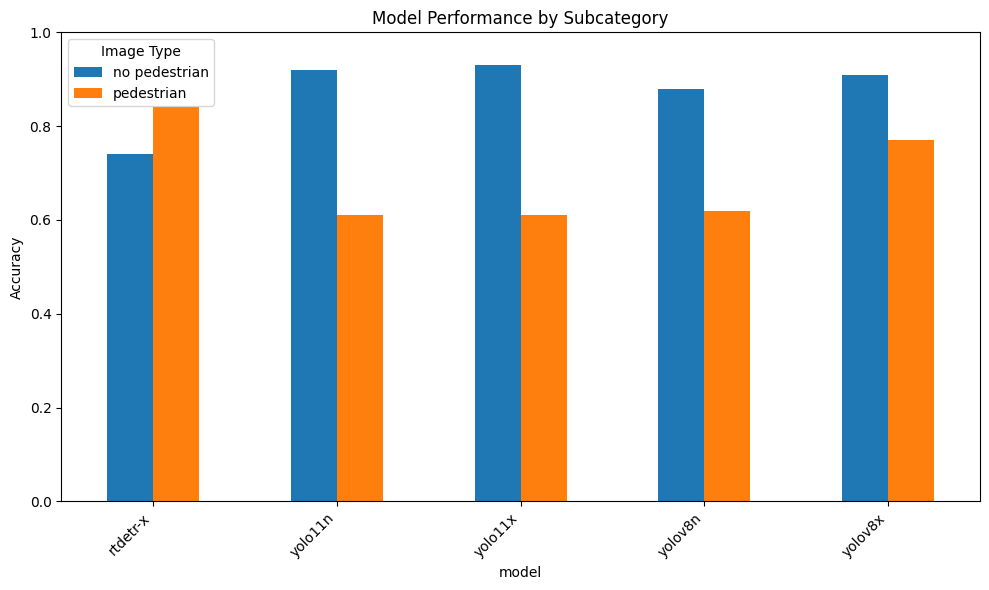

In [ ]:
model_subcat_perf = (
    merged_df.groupby(["model", "correct_response"], as_index=False)["correct"]
    .mean()
    .rename(columns={"correct": "accuracy"})
)

model_subcat_perf["subcategory"] = model_subcat_perf["correct_response"].map(
    {1: "pedestrian", 2: "no pedestrian"}
)

pivot_df = model_subcat_perf.pivot(index="model", columns="subcategory", values="accuracy")

pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("Model Performance by Subcategory")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  
plt.xticks(rotation=45, ha="right")
plt.legend(title="Image Type")
plt.tight_layout()
plt.savefig('ml_sub_acc_histogram.png')
plt.show()


In [ ]:
image_model_type_perf = (
    merged_df.groupby(["image_name", "model", "correct_response"])["correct"]
    .mean()
    .reset_index()
)

pedestrian = image_model_type_perf[image_model_type_perf["correct_response"] == 1]
no_pedestrian = image_model_type_perf[image_model_type_perf["correct_response"] == 2]

anova_ped = stats.f_oneway(
    *[pedestrian[pedestrian["model"] == m]["correct"] for m in pedestrian["model"].unique()]
)

anova_noped = stats.f_oneway(
    *[no_pedestrian[no_pedestrian["model"] == m]["correct"] for m in no_pedestrian["model"].unique()]
)

print("ANOVA Pedestrian Images:", anova_ped)
print("ANOVA No-Pedestrian Images:", anova_noped)


ANOVA Pedestrian Images: F_onewayResult(statistic=np.float64(5.637647863916318), pvalue=np.float64(0.00019176069645966234))
ANOVA No-Pedestrian Images: F_onewayResult(statistic=np.float64(5.851041264944079), pvalue=np.float64(0.00013175364108073862))


In [30]:
for model in merged_df["model"].unique():
    model_perf = (
        merged_df[merged_df["model"] == model]
        .groupby("image_name")["correct"]
        .mean()
    )
    
    t_stat, p_val = stats.ttest_1samp(model_perf, 0.5)
    print(f"{model}: t={t_stat:.2f}, p={p_val:.3e}")

yolo11n: t=8.82, p=5.927e-16
yolo11x: t=9.05, p=1.310e-16
yolov8n: t=8.14, p=4.124e-14
yolov8x: t=13.08, p=1.252e-28
rtdetr-x: t=10.04, p=1.837e-19
